In [1]:
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import optuna
from train import Trainer
from dataset import DataPreparation
from models import *
from eval import evaluate_model
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Thiết bị sử dụng (cuda hoặc cpu)
        self.train_dir = "../../dataset/train/"  # Đường dẫn đến dữ liệu huấn luyện
        self.test_dir = '../../dataset/test/'
        self.num_classes = None
        self.class_names = None
        self.batch_size = 64
        self.max_epochs = 5
        self.patience = 3
        self.lr = 0.0001
        self.beta1 = 0.95
        self.beta2 = 0.993

In [3]:
# Loss
criterion = nn.CrossEntropyLoss()

In [4]:
cfg = Config()
data_preparation = DataPreparation(
    cfg = cfg
    )

Số lượng lớp: 6
Tên lớp: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Ánh xạ từ tên lớp sang chỉ số: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of train:  14034
Number of test:  3000


In [5]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 6, 8, 16, 32])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    beta1 = trial.suggest_float("beta1", 0.9, 0.99, step=0.01)
    beta2 = trial.suggest_float("beta2", 0.99, 0.999, step=0.001)
    
    # Update configs
    cfg.beta1 = beta1
    cfg.beta2 = beta2
    cfg.batch_size = batch_size
    cfg.lr = learning_rate
    

    # Create dataloader
    data_preparation.create_data_loaders()
    trainloader = data_preparation.trainloader
    testloader = data_preparation.testloader
    cfg.num_classes = data_preparation.num_classes
    cfg.class_names = data_preparation.classes_name
    
    # Create Model
    model = mobilenetv3_frozen(cfg.num_classes)

    # Create Trainer
    trainer = Trainer(
        model = model, 
        train_loader=trainloader, 
        test_loader=testloader,
        cfg=cfg
    )
    
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

    # Training
    trainer.train(
        optimizer=optimizer, 
        scheduler=None,
        criterion=criterion
    )
    best_model = trainer.model_best_loss
    all_predictions, all_true_labels = evaluate_model(
        model=best_model, 
        test_dataloader = testloader, 
        device = cfg.device, 
        class_names = data_preparation.classes_name
    )
    f1 = f1_score(all_true_labels, all_predictions, average='weighted')
    return f1


[I 2023-10-21 15:24:20,795] A new study created in memory with name: Image Classificaion with Transfer Leanring
epochs:  20%|██        | 1/5 [01:50<07:20, 110.03s/it]

Epoch 1/5 - Train Loss: 3.6304 - Test Loss: 0.4692 - Train F1: 0.7602 - Test F1: 0.8427


epochs:  40%|████      | 2/5 [02:28<03:24, 68.11s/it] 

Epoch 2/5 - Train Loss: 0.5603 - Test Loss: 0.4261 - Train F1: 0.8211 - Test F1: 0.8693


epochs:  60%|██████    | 3/5 [03:04<01:46, 53.42s/it]

Epoch 3/5 - Train Loss: 0.5531 - Test Loss: 0.5931 - Train F1: 0.8226 - Test F1: 0.8203


epochs:  80%|████████  | 4/5 [03:40<00:46, 46.41s/it]

Epoch 4/5 - Train Loss: 0.6317 - Test Loss: 0.5441 - Train F1: 0.8038 - Test F1: 0.8350


epochs:  80%|████████  | 4/5 [04:15<01:03, 63.94s/it]


Epoch 5/5 - Train Loss: 0.6810 - Test Loss: 0.5199 - Train F1: 0.7771 - Test F1: 0.8400
Early stopping triggered.
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.35it/s]


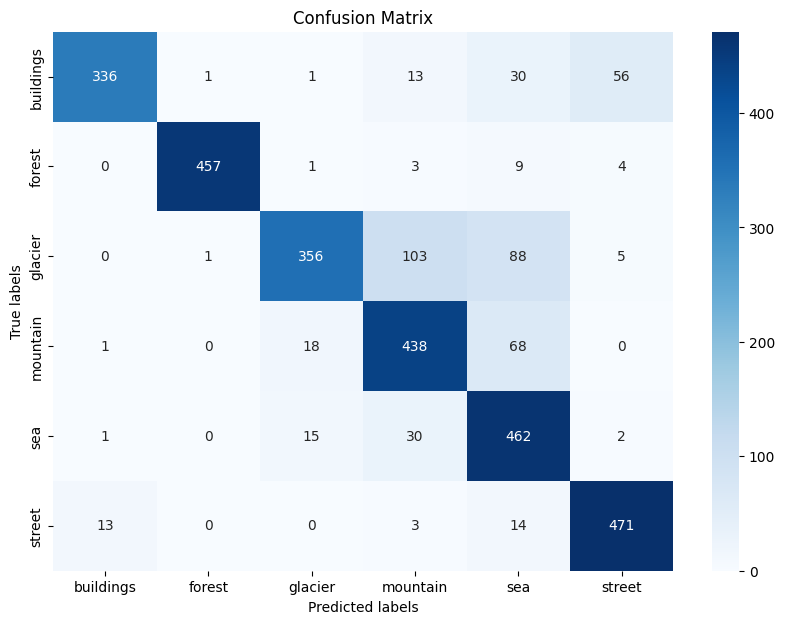

[I 2023-10-21 15:28:44,254] Trial 0 finished with value: 0.8399406095725664 and parameters: {'batch_size': 8, 'learning_rate': 0.05010961810707388, 'beta1': 0.9400000000000001, 'beta2': 0.996}. Best is trial 0 with value: 0.8399406095725664.
epochs:  20%|██        | 1/5 [00:35<02:22, 35.67s/it]

Epoch 1/5 - Train Loss: 1.4671 - Test Loss: 1.1327 - Train F1: 0.5040 - Test F1: 0.7440


epochs:  40%|████      | 2/5 [01:11<01:47, 35.72s/it]

Epoch 2/5 - Train Loss: 0.9201 - Test Loss: 0.7351 - Train F1: 0.7775 - Test F1: 0.8317


epochs:  60%|██████    | 3/5 [01:47<01:11, 35.67s/it]

Epoch 3/5 - Train Loss: 0.6493 - Test Loss: 0.5481 - Train F1: 0.8293 - Test F1: 0.8497


epochs:  80%|████████  | 4/5 [02:22<00:35, 35.66s/it]

Epoch 4/5 - Train Loss: 0.5076 - Test Loss: 0.4554 - Train F1: 0.8512 - Test F1: 0.8577


epochs: 100%|██████████| 5/5 [02:58<00:00, 35.63s/it]


Epoch 5/5 - Train Loss: 0.4399 - Test Loss: 0.4042 - Train F1: 0.8594 - Test F1: 0.8680
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.37it/s]


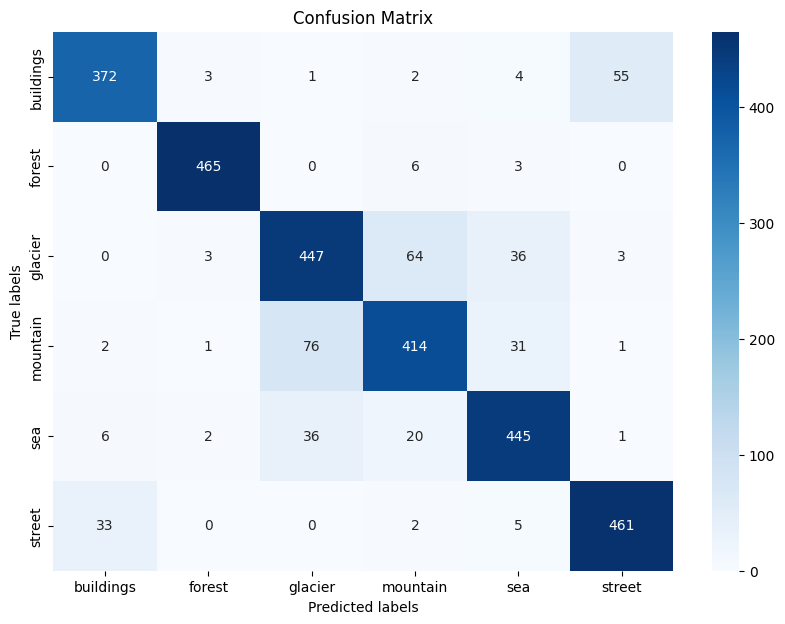

[I 2023-10-21 15:31:49,123] Trial 1 finished with value: 0.8678195675692778 and parameters: {'batch_size': 16, 'learning_rate': 1.5043012591712422e-05, 'beta1': 0.9400000000000001, 'beta2': 0.992}. Best is trial 1 with value: 0.8678195675692778.
epochs:  20%|██        | 1/5 [00:35<02:21, 35.47s/it]

Epoch 1/5 - Train Loss: 0.6707 - Test Loss: 0.2951 - Train F1: 0.8392 - Test F1: 0.8943


epochs:  40%|████      | 2/5 [01:11<01:46, 35.55s/it]

Epoch 2/5 - Train Loss: 0.3180 - Test Loss: 0.2999 - Train F1: 0.8933 - Test F1: 0.9037


epochs:  60%|██████    | 3/5 [01:46<01:10, 35.42s/it]

Epoch 3/5 - Train Loss: 0.3195 - Test Loss: 0.3251 - Train F1: 0.8980 - Test F1: 0.8960


epochs:  60%|██████    | 3/5 [02:21<01:34, 47.30s/it]


Epoch 4/5 - Train Loss: 0.3143 - Test Loss: 0.3150 - Train F1: 0.9004 - Test F1: 0.8940
Early stopping triggered.
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.25it/s]


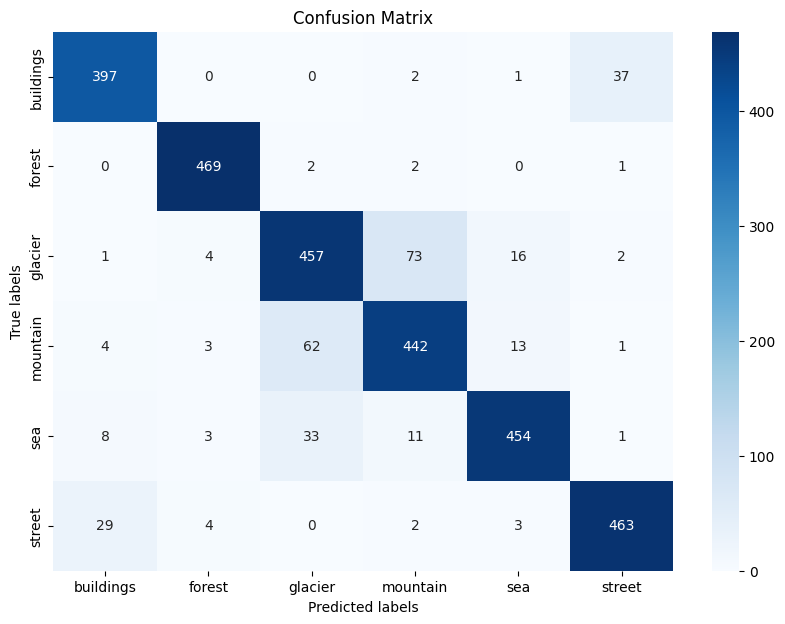

[I 2023-10-21 15:34:17,765] Trial 2 finished with value: 0.8939918117352219 and parameters: {'batch_size': 8, 'learning_rate': 0.013215061281850618, 'beta1': 0.97, 'beta2': 0.994}. Best is trial 2 with value: 0.8939918117352219.
epochs:  20%|██        | 1/5 [00:35<02:22, 35.73s/it]

Epoch 1/5 - Train Loss: 0.4873 - Test Loss: 0.3153 - Train F1: 0.8488 - Test F1: 0.8970


epochs:  40%|████      | 2/5 [01:11<01:47, 35.73s/it]

Epoch 2/5 - Train Loss: 0.3061 - Test Loss: 0.3150 - Train F1: 0.8945 - Test F1: 0.8970


epochs:  60%|██████    | 3/5 [01:48<01:12, 36.11s/it]

Epoch 3/5 - Train Loss: 0.2787 - Test Loss: 0.2853 - Train F1: 0.9064 - Test F1: 0.9033


epochs:  80%|████████  | 4/5 [02:22<00:35, 35.56s/it]

Epoch 4/5 - Train Loss: 0.2571 - Test Loss: 0.3367 - Train F1: 0.9094 - Test F1: 0.8873


epochs: 100%|██████████| 5/5 [02:57<00:00, 35.57s/it]


Epoch 5/5 - Train Loss: 0.2492 - Test Loss: 0.3548 - Train F1: 0.9157 - Test F1: 0.9020
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.40it/s]


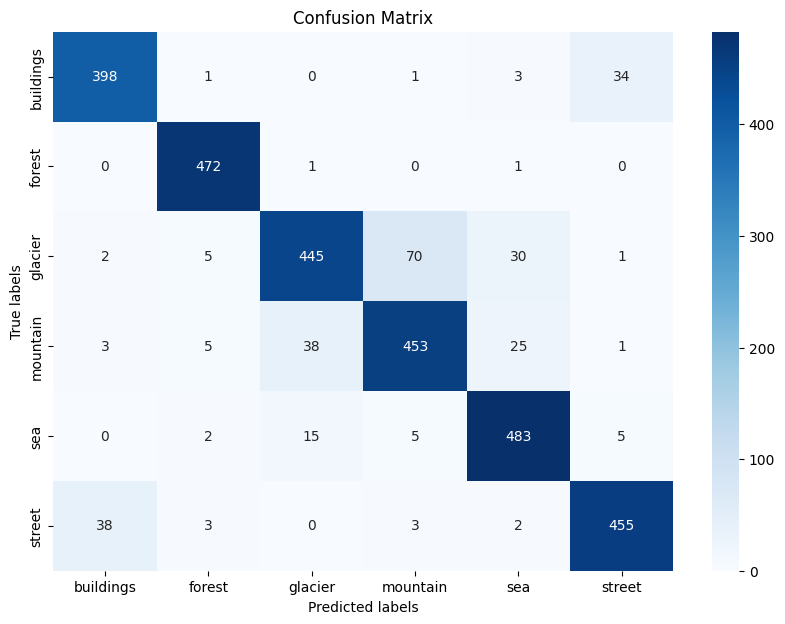

[I 2023-10-21 15:37:22,258] Trial 3 finished with value: 0.901287056994796 and parameters: {'batch_size': 2, 'learning_rate': 0.009987916762022599, 'beta1': 0.93, 'beta2': 0.997}. Best is trial 3 with value: 0.901287056994796.
epochs:  20%|██        | 1/5 [00:34<02:19, 34.82s/it]

Epoch 1/5 - Train Loss: 1.4403 - Test Loss: 1.1002 - Train F1: 0.5194 - Test F1: 0.7647


epochs:  40%|████      | 2/5 [01:09<01:44, 34.87s/it]

Epoch 2/5 - Train Loss: 0.9189 - Test Loss: 0.7226 - Train F1: 0.7768 - Test F1: 0.8310


epochs:  60%|██████    | 3/5 [01:44<01:09, 34.83s/it]

Epoch 3/5 - Train Loss: 0.6503 - Test Loss: 0.5425 - Train F1: 0.8293 - Test F1: 0.8527


epochs:  80%|████████  | 4/5 [02:19<00:34, 34.82s/it]

Epoch 4/5 - Train Loss: 0.5160 - Test Loss: 0.4509 - Train F1: 0.8503 - Test F1: 0.8617


epochs: 100%|██████████| 5/5 [02:54<00:00, 34.85s/it]


Epoch 5/5 - Train Loss: 0.4504 - Test Loss: 0.4018 - Train F1: 0.8566 - Test F1: 0.8690
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.47it/s]


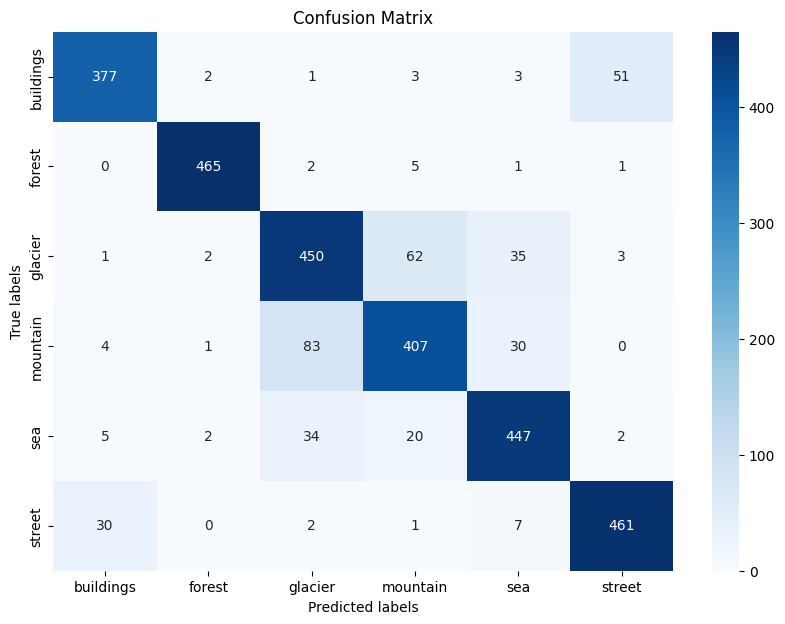

[I 2023-10-21 15:40:23,111] Trial 4 finished with value: 0.8688792751838834 and parameters: {'batch_size': 4, 'learning_rate': 1.382856523210809e-05, 'beta1': 0.99, 'beta2': 0.997}. Best is trial 3 with value: 0.901287056994796.
epochs:  20%|██        | 1/5 [00:35<02:20, 35.14s/it]

Epoch 1/5 - Train Loss: 0.4089 - Test Loss: 0.2803 - Train F1: 0.8545 - Test F1: 0.8990


epochs:  40%|████      | 2/5 [01:09<01:44, 34.91s/it]

Epoch 2/5 - Train Loss: 0.2385 - Test Loss: 0.2818 - Train F1: 0.9141 - Test F1: 0.8957


epochs:  60%|██████    | 3/5 [01:44<01:09, 34.84s/it]

Epoch 3/5 - Train Loss: 0.1848 - Test Loss: 0.2701 - Train F1: 0.9300 - Test F1: 0.9117


epochs:  80%|████████  | 4/5 [02:20<00:35, 35.10s/it]

Epoch 4/5 - Train Loss: 0.1465 - Test Loss: 0.2664 - Train F1: 0.9463 - Test F1: 0.9077


epochs: 100%|██████████| 5/5 [02:54<00:00, 35.00s/it]


Epoch 5/5 - Train Loss: 0.1165 - Test Loss: 0.3046 - Train F1: 0.9562 - Test F1: 0.9140
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.57it/s]


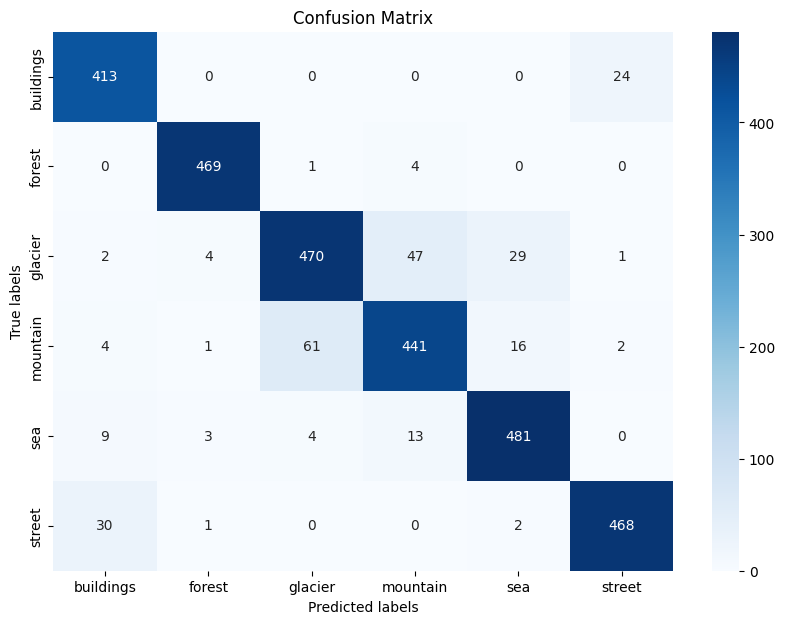

[I 2023-10-21 15:43:24,573] Trial 5 finished with value: 0.913572419613816 and parameters: {'batch_size': 6, 'learning_rate': 0.0018946546007255524, 'beta1': 0.99, 'beta2': 0.991}. Best is trial 5 with value: 0.913572419613816.
epochs:  20%|██        | 1/5 [00:34<02:19, 34.98s/it]

Epoch 1/5 - Train Loss: 0.5150 - Test Loss: 0.3010 - Train F1: 0.8251 - Test F1: 0.8933


epochs:  40%|████      | 2/5 [01:09<01:44, 34.78s/it]

Epoch 2/5 - Train Loss: 0.2990 - Test Loss: 0.2855 - Train F1: 0.8908 - Test F1: 0.8970


epochs:  60%|██████    | 3/5 [01:45<01:10, 35.29s/it]

Epoch 3/5 - Train Loss: 0.2623 - Test Loss: 0.2695 - Train F1: 0.9068 - Test F1: 0.8980


epochs:  80%|████████  | 4/5 [02:21<00:35, 35.63s/it]

Epoch 4/5 - Train Loss: 0.2416 - Test Loss: 0.2764 - Train F1: 0.9149 - Test F1: 0.8990


epochs: 100%|██████████| 5/5 [02:59<00:00, 35.84s/it]


Epoch 5/5 - Train Loss: 0.2160 - Test Loss: 0.2565 - Train F1: 0.9233 - Test F1: 0.9050
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.50it/s]


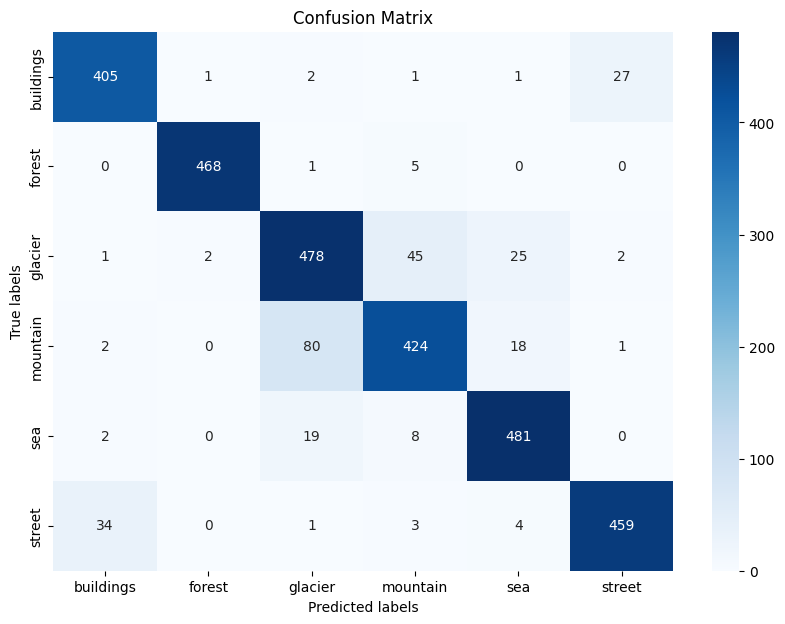

[I 2023-10-21 15:46:30,333] Trial 6 finished with value: 0.9048630242607641 and parameters: {'batch_size': 8, 'learning_rate': 0.00021260678894596317, 'beta1': 0.9400000000000001, 'beta2': 0.995}. Best is trial 5 with value: 0.913572419613816.
epochs:  20%|██        | 1/5 [00:34<02:19, 34.80s/it]

Epoch 1/5 - Train Loss: 3.6116 - Test Loss: 1.2605 - Train F1: 0.6968 - Test F1: 0.7697


epochs:  40%|████      | 2/5 [01:09<01:44, 34.74s/it]

Epoch 2/5 - Train Loss: 0.8651 - Test Loss: 0.6186 - Train F1: 0.7235 - Test F1: 0.7930


epochs:  60%|██████    | 3/5 [01:44<01:10, 35.02s/it]

Epoch 3/5 - Train Loss: 0.8222 - Test Loss: 0.6492 - Train F1: 0.7433 - Test F1: 0.7970


epochs:  80%|████████  | 4/5 [02:19<00:34, 34.99s/it]

Epoch 4/5 - Train Loss: 0.8004 - Test Loss: 0.6356 - Train F1: 0.7411 - Test F1: 0.7957


epochs:  80%|████████  | 4/5 [02:54<00:43, 43.72s/it]


Epoch 5/5 - Train Loss: 0.7969 - Test Loss: 0.6223 - Train F1: 0.7397 - Test F1: 0.8637
Early stopping triggered.
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.67it/s]


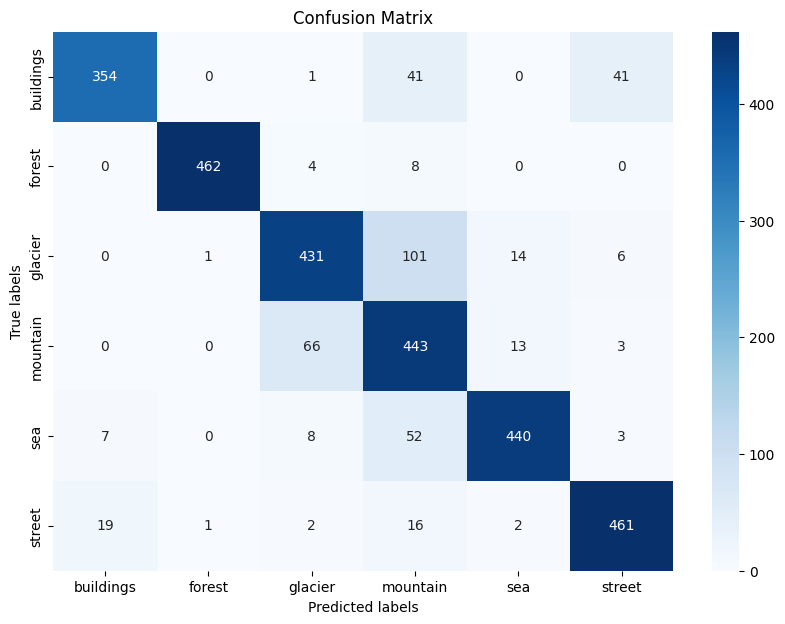

[I 2023-10-21 15:49:32,560] Trial 7 finished with value: 0.8663129143822327 and parameters: {'batch_size': 6, 'learning_rate': 0.04540773323254817, 'beta1': 0.99, 'beta2': 0.992}. Best is trial 5 with value: 0.913572419613816.
epochs:  20%|██        | 1/5 [00:35<02:20, 35.23s/it]

Epoch 1/5 - Train Loss: 0.4063 - Test Loss: 0.2740 - Train F1: 0.8565 - Test F1: 0.8963


epochs:  40%|████      | 2/5 [01:10<01:45, 35.30s/it]

Epoch 2/5 - Train Loss: 0.2568 - Test Loss: 0.2659 - Train F1: 0.9119 - Test F1: 0.9060


epochs:  60%|██████    | 3/5 [01:45<01:10, 35.18s/it]

Epoch 3/5 - Train Loss: 0.2164 - Test Loss: 0.2592 - Train F1: 0.9225 - Test F1: 0.9033


epochs:  80%|████████  | 4/5 [02:20<00:35, 35.02s/it]

Epoch 4/5 - Train Loss: 0.1842 - Test Loss: 0.2516 - Train F1: 0.9354 - Test F1: 0.9080


epochs: 100%|██████████| 5/5 [02:55<00:00, 35.11s/it]


Epoch 5/5 - Train Loss: 0.1600 - Test Loss: 0.2523 - Train F1: 0.9424 - Test F1: 0.9097
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.59it/s]


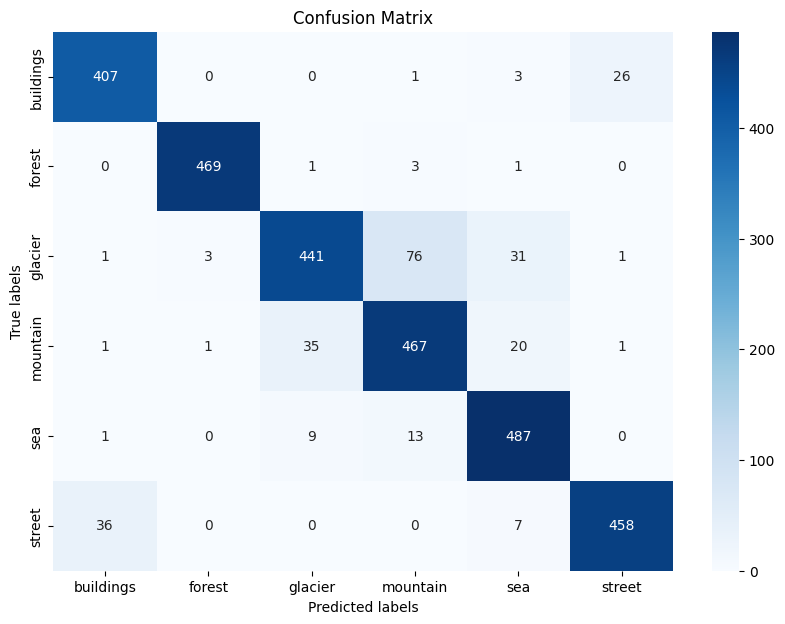

[I 2023-10-21 15:52:34,545] Trial 8 finished with value: 0.9092486457865486 and parameters: {'batch_size': 6, 'learning_rate': 0.0005995119031590906, 'beta1': 0.9400000000000001, 'beta2': 0.994}. Best is trial 5 with value: 0.913572419613816.
epochs:  20%|██        | 1/5 [00:34<02:19, 34.85s/it]

Epoch 1/5 - Train Loss: 0.5939 - Test Loss: 0.3204 - Train F1: 0.8045 - Test F1: 0.8827


epochs:  40%|████      | 2/5 [01:10<01:45, 35.05s/it]

Epoch 2/5 - Train Loss: 0.3142 - Test Loss: 0.2895 - Train F1: 0.8860 - Test F1: 0.8947


epochs:  60%|██████    | 3/5 [01:44<01:09, 34.95s/it]

Epoch 3/5 - Train Loss: 0.2798 - Test Loss: 0.2830 - Train F1: 0.9008 - Test F1: 0.9000


epochs:  80%|████████  | 4/5 [02:20<00:35, 35.35s/it]

Epoch 4/5 - Train Loss: 0.2537 - Test Loss: 0.2653 - Train F1: 0.9104 - Test F1: 0.9037


epochs: 100%|██████████| 5/5 [02:55<00:00, 35.15s/it]


Epoch 5/5 - Train Loss: 0.2391 - Test Loss: 0.2675 - Train F1: 0.9134 - Test F1: 0.9033
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.54it/s]


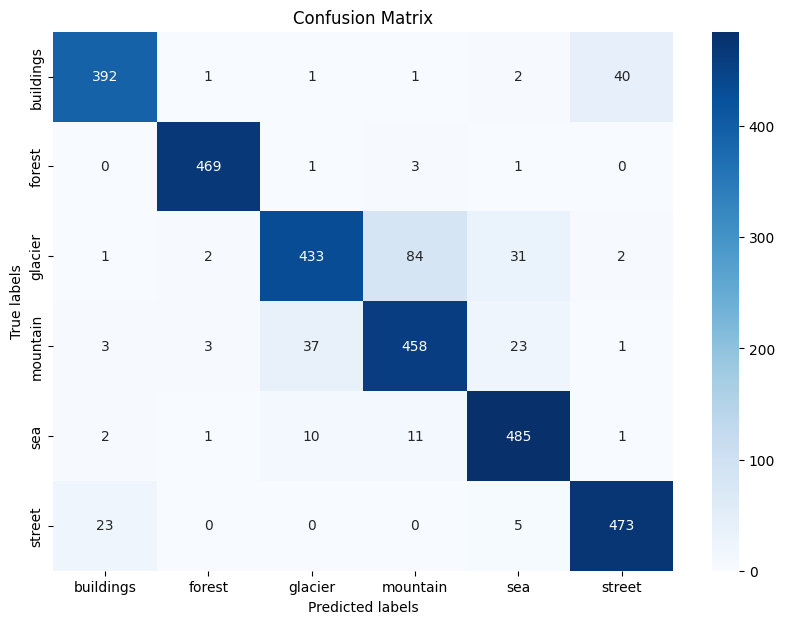

[I 2023-10-21 15:55:36,805] Trial 9 finished with value: 0.9026897570400763 and parameters: {'batch_size': 2, 'learning_rate': 0.0001485292490320942, 'beta1': 0.9400000000000001, 'beta2': 0.99}. Best is trial 5 with value: 0.913572419613816.


In [6]:
study_name = "Image Classificaion with Transfer Leanring"
study = optuna.create_study(
    study_name=study_name,
    direction="maximize"
    )
study.optimize(objective, n_trials=10)

In [7]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  10
Best trial:
Value:  0.913572419613816
Params: 
    batch_size: 6
    learning_rate: 0.0018946546007255524
    beta1: 0.99
    beta2: 0.991


In [8]:
trial.params

{'batch_size': 6,
 'learning_rate': 0.0018946546007255524,
 'beta1': 0.99,
 'beta2': 0.991}

epochs:  20%|██        | 1/5 [00:34<02:19, 34.75s/it]

Epoch 1/5 - Train Loss: 0.4405 - Test Loss: 0.2813 - Train F1: 0.8486 - Test F1: 0.8993


epochs:  40%|████      | 2/5 [01:09<01:43, 34.50s/it]

Epoch 2/5 - Train Loss: 0.2414 - Test Loss: 0.2615 - Train F1: 0.9140 - Test F1: 0.9080


epochs:  60%|██████    | 3/5 [01:44<01:09, 34.74s/it]

Epoch 3/5 - Train Loss: 0.1938 - Test Loss: 0.2610 - Train F1: 0.9287 - Test F1: 0.9093


epochs:  80%|████████  | 4/5 [02:18<00:34, 34.59s/it]

Epoch 4/5 - Train Loss: 0.1436 - Test Loss: 0.2798 - Train F1: 0.9467 - Test F1: 0.9097


epochs: 100%|██████████| 5/5 [02:53<00:00, 34.67s/it]


Epoch 5/5 - Train Loss: 0.1131 - Test Loss: 0.2733 - Train F1: 0.9568 - Test F1: 0.9163
Training finished.


eval: 100%|██████████| 47/47 [00:06<00:00,  7.61it/s]


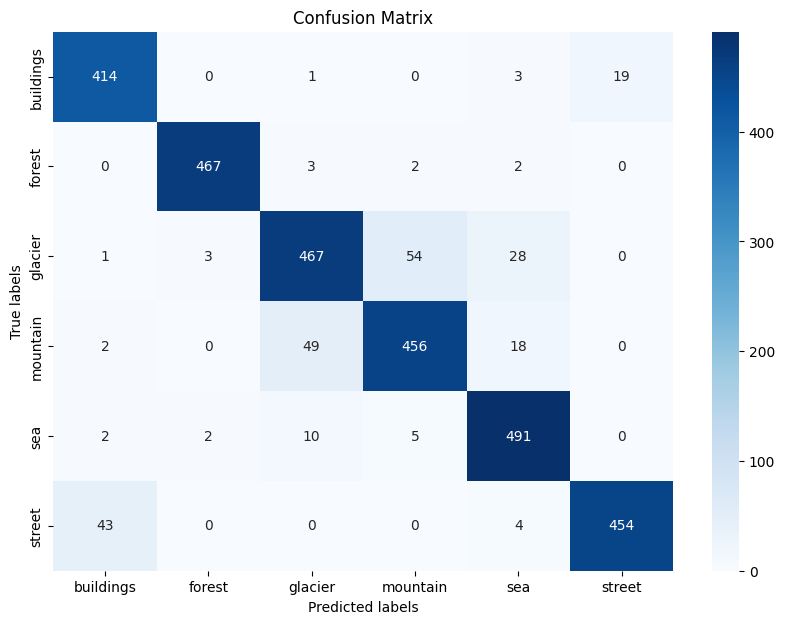

In [9]:
# Update configs
cfg.beta1 = trial.params['beta1']
cfg.beta2 = trial.params['beta2']
cfg.batch_size = trial.params['batch_size']
cfg.lr = trial.params['learning_rate']


# Create dataloader
data_preparation.create_data_loaders()
trainloader = data_preparation.trainloader
testloader = data_preparation.testloader
cfg.num_classes = data_preparation.num_classes
cfg.class_names = data_preparation.classes_name

# Create Model
model = mobilenetv3_frozen(cfg.num_classes)

# Create Trainer
trainer = Trainer(
    model = model, 
    train_loader=trainloader, 
    test_loader=testloader,
    cfg=cfg
)

optimizer = optim.Adam(model.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

# Training
trainer.train(
    optimizer=optimizer, 
    scheduler=None,
    criterion=criterion
)
best_model = trainer.model_best_loss
all_predictions, all_true_labels = evaluate_model(
    model=best_model, 
    test_dataloader = testloader, 
    device = cfg.device, 
    class_names = data_preparation.classes_name
)
f1 = f1_score(all_true_labels, all_predictions, average='weighted')

In [10]:
f1

0.9160686673063166

In [11]:
torch.save(best_model, 'best_model_tuning.pth')